# Welcome to the ATLAS Open Data Collective Compression Autoencoder experiment!

This is an autoencoder implemented using pytorch. It builds upon previous work done by Eric Wulff, Erik Wallin, Jessica Lastow and Honey Gupta. See for example: https://github.com/Autoencoders-compression-anomaly/AE-Compression-pytorch

The autoencoder compresses jet four-momentum data in two steps. First, single jets are compressed into three-dimensional latent space representations (based on the work done by Eric Wulff in his master's thesis). Secondly, groups of jet representations are concatenated and collectively compressed further. The information is then decoded, and evaluation metrics examined.

The data used in this example comes from the ATLAS Open Data release of 2020. It can be downloaded from the following site: http://opendata.cern.ch/record/15007

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

### Load data from ROOT file
Note that these files range in size from small to very large.

Change the "filename" statement to switch between MC and real data.

In [15]:
start = time.perf_counter()

MC_path = r'F:\Master\Data\2lep\MC' # path to MC files
MC_filename = r'mc_364118.Zee_PTV70_140_CFilterBVeto.2lep.root'

ATLAS_path = r'F:\Master\Data\2lep\Data' # path to real data files
ATLAS_filename = r'data_B.2lep.root'

# Select MC or real data
#filename, data_type = os.sep.join([MC_path, MC_filename]), 'MC'
filename, data_type = os.sep.join([ATLAS_path, ATLAS_filename]), 'real'

with uproot.open(filename) as file:
    print('Loading', data_type, 'data from file:', filename)
    print('ROOT data file size: {:.2f}'.format(os.path.getsize(filename) * 1e-6), 'MB')
    print('...')
    root_data = file['mini'].arrays(library='pd')
    print('Loading complete!')

end = time.perf_counter()
print('ROOT -> pandas conversion time: {:.2f}'.format(end-start), 'seconds')

Loading real data from file: F:\Master\Data\2lep\Data\data_B.2lep.root
ROOT data file size: 480.64 MB
...
Loading complete!
ROOT -> pandas conversion time: 202.54 seconds


### Separate lepton and jet data
The network can also be trained using lepton data, but this exampl only uses jet data.

In [16]:
if data_type == 'MC':
    root_lep_data = root_data[0]
    root_jet_data = root_data[1]
else:
    root_lep_data = root_data[1]
    root_jet_data = root_data[2]

dataset_name = data_type + ' data, ' + filename

### Select events based on number of jets
This autoencoder compresses groups of jets. The default setup of this example groups the jets from events with exactly four jets. This does not necessarily give the best results - the four jets in a four-jet event are quite dissimilar. If one wishes to reduce compression error, it is likely better to group similar jets, e.g. four leading jets, four sub-leading jets, etc. Results on this are forthcoming!

In [17]:
# Get events with a specific number of jets
jet_n = 4

mask = (root_jet_data['jet_n'] == jet_n)
jet_branches = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_E']
jet_data = root_jet_data[jet_branches][mask]

# Get specific jets out of those events
wanted_sub_ixs = [0, 1, 2, 3] # sub index 0 corresponds to jet 1, index 1 to jet 2, etc.
ixs = jet_data.index
main_ixs = [ix[0] for ix in ixs]
sub_ixs = [ix[1] for ix in ixs]
sub_in_range = [sub_ix in wanted_sub_ixs for sub_ix in sub_ixs]
jet_data = jet_data[sub_in_range]

print('Total number of jets in ROOT data:', len(root_jet_data))
print('Number of jets in selection:', len(jet_data))

Total number of jets in ROOT data: 1700320
Number of jets in selection: 139688


### Visualize the data
This gives an idea of the distributions of the variables and the scales involved, as well as if the data has any outliers.

Viewing the real data, F:\Master\Data\2lep\Data\data_B.2lep.root
Number of jet four-momenta: 139688


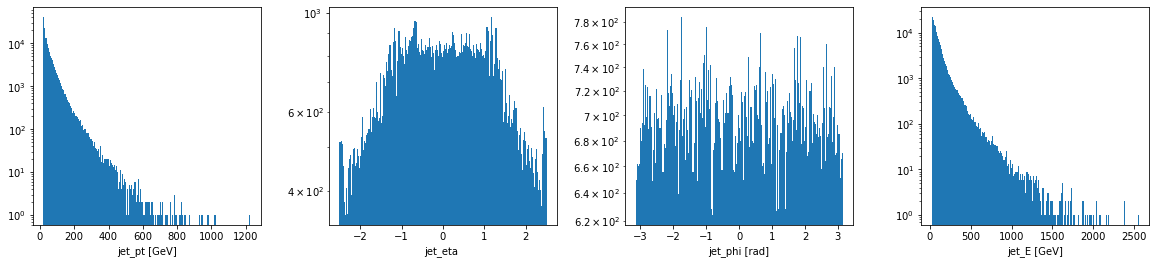

In [56]:
n_bins = 200

print('Viewing the ' + dataset_name)

units = ['[GeV]', '', '[rad]', '[GeV]']  
multiplier = [1e-3, 1, 1, 1e-3, 1, 1]

fig = plt.figure(figsize=(5*len(jet_branches), 4))
for i, branch in enumerate(jet_branches):
    plt.subplot(1, len(jet_branches), i+1)
    plt.hist(jet_data[branch] * multiplier[i], bins=n_bins)
    ax = plt.gca()
    ax.set_xlabel(branch + ' ' + units[i])
    plt.yscale('log')
plt.subplots_adjust(wspace=0.3)
    
n_jets = len(jet_data)

print('Number of jet four-momenta:', n_jets)

### Normalize data and divide into training and testing datasets
Autoencoder performance depends on the scale of the input data. In this example, all variables are normalized to be in approximately the same range.

Viewing normalized data.


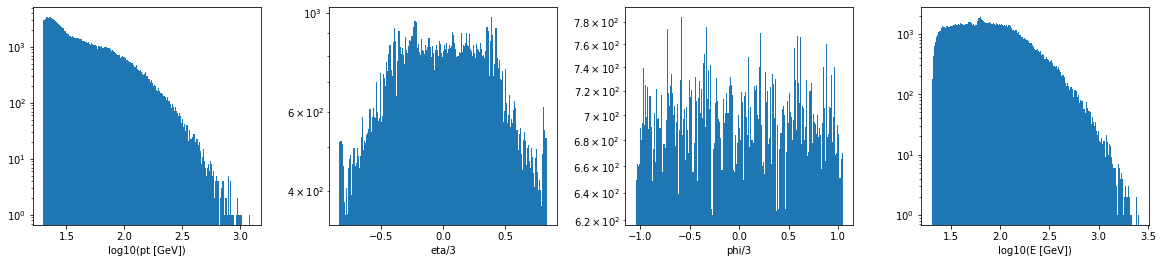

In [55]:
from satools import normalize, make_DataLoaders

dataset = normalize(jet_data.values)

# The dataset is split so that 80% becomes training data and the remaining 20% testing data
train_idxs = (0, int(len(dataset) * 4 / 5))
test_idxs = (train_idxs[1], len(dataset))

train = dataset[train_idxs[0]:train_idxs[1]]
test = dataset[test_idxs[0]:test_idxs[1]]

batch_size = 256

dls = make_DataLoaders(train, test, batch_size)

labels = ['log10(pt [GeV])', 'eta/3', 'phi/3', 'log10(E [GeV])']

print('Viewing normalized data.')

fig = plt.figure(figsize=(5*len(jet_branches), 4))
for i, branch in enumerate(jet_branches):
    plt.subplot(1, len(jet_branches), i+1)
    plt.hist(dataset[:, i], bins=n_bins)
    ax = plt.gca()
    ax.set_xlabel(labels[i])
    plt.yscale('log')
plt.subplots_adjust(wspace=0.3)

### Single jet AE
Define model for the single-jet AE and instantiate it.

In [20]:
class Model(nn.Module):
    def __init__(self, n_features=4, latent_space_size=3):
        super(Model, self).__init__()      
        
        self.n_features = n_features
        self.latent_space_size = latent_space_size
        
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, latent_space_size)
        self.de1 = nn.Linear(latent_space_size, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.act = nn.Tanh()
    
    def encode(self, x):
        return self.en4(self.act(self.en3(self.act(self.en2(self.act(self.en1(x)))))))
    
    def decode(self, x):
        return self.de4(self.act(self.de3(self.act(self.de2(self.act(self.de1(self.act(x))))))))
    
    def forward(self, x, mode = 'both'):
        assert mode in ['both', 'encode', 'decode'], 'model expects keyword mode to be \'encode\', \'decode\' or \'both\'.'
        if mode == 'encode':
            return self.encode(x)
        elif mode == 'decode':
            return self.decode(x)
        else:
            z = self.encode(x)
            return self.decode(z)
    
    def describe(self):
        return str(self.n_features) + '-200-200-20-' + str(self.latent_space_size) + '-20-200-200-' + str(self.n_features) + ', activation function: ' + str(self.act)

In [21]:
n_features = jet_data.shape[1]
latent_space_size = 3
if not latent_space_size < n_features:
    print('WARNING! Dimensionality of latent space is not lower than that of input data! Is this intended?')

print('Number of features in input data:', n_features)
print('Latent space size:', latent_space_size)
model = Model(n_features=n_features, latent_space_size=latent_space_size)
model.to('cpu')
print(model.describe())

Number of features in input data: 4
Latent space size: 3
4-200-200-20-3-20-200-200-4, activation function: Tanh()


### Initializing the first network, single-vector encoding

In [22]:
# Set up the model and learner

loss_func = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_func, cbs=recorder)

### Either load a saved model...

In [23]:
# Option to load a model

load_filename = 'd300'
load = True
if load:
    learn.load(load_filename)
    print('Loaded model', load_filename)

Loaded model d300


### ...or, train a the network

Learning rate with the minimum loss: 0.004786301031708717
Learning rate with the steepest gradient: 0.0010000000474974513


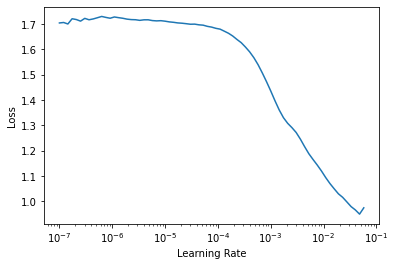

In [68]:
# Use Learner to find good learning rates

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [69]:
# Train the model

n_epoch = 300
lr_max = lr_min

print('Training single-vector AE:', model.describe())
print('Training on dataset:', filename)

start = time.perf_counter()
learn.fit_one_cycle(n_epoch=n_epoch, lr_max=lr_max)
end = time.perf_counter()
delta_t = end - start
print('Training took', delta_t, 'seconds')

Training single-vector AE: 4-200-200-20-3-20-200-200-4, activation function: Tanh()
Training on dataset: F:\Master\Data\2lep\Data\data_D.2lep.root
[0, 0.0003378638648428023, 0.00022057780006434768, '00:09']
[0, 0.0003378638648428023, 0.00022057780006434768, '00:09']
[1, 3.409692726563662e-05, 3.0058792617637664e-05, '00:08']
[1, 3.409692726563662e-05, 3.0058792617637664e-05, '00:08']
[2, 2.059702637779992e-05, 1.865838021331001e-05, '00:08']
[2, 2.059702637779992e-05, 1.865838021331001e-05, '00:08']
[3, 1.3944499187346082e-05, 1.0901180758082774e-05, '00:09']
[3, 1.3944499187346082e-05, 1.0901180758082774e-05, '00:09']
[4, 1.6933139704633504e-05, 9.738018889038358e-06, '00:08']
[4, 1.6933139704633504e-05, 9.738018889038358e-06, '00:08']
[5, 1.623299795028288e-05, 2.0678751752711833e-05, '00:08']
[5, 1.623299795028288e-05, 2.0678751752711833e-05, '00:08']
[6, 9.771693839866202e-06, 1.0032616955868434e-05, '00:08']
[6, 9.771693839866202e-06, 1.0032616955868434e-05, '00:08']
[7, 1.2250496

Loss as a function of batches trained:


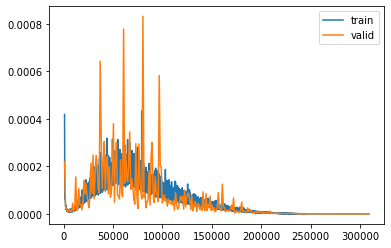


Learning rate and momentum as functions of batches trained:


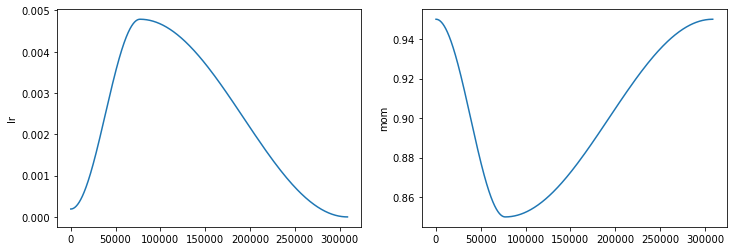

In [71]:
print('Loss as a function of batches trained:')
recorder.plot_loss(skip_start = 1000)
plt.show()
print()
print('Learning rate and momentum as functions of batches trained:')
recorder.plot_sched()
plt.show()

In [11]:
# Option to save the model

save_filename = 'd300'
save = False
if save & os.path.isfile('./models/'+save_filename+'.pth'):
    save = False
    print('File already exists! Aborting.')
if save:
    learn.save(save_filename) # Default path used by Learner is ./models/
    print(save_filename, 'saved.')

### Create histograms comparing input testing data to AE reconstruction

Viewing the real data, F:\Master\Data\2lep\Data\data_B.2lep.root
Number of jets in test set: 27938
Using AE architecture 4-200-200-20-3-20-200-200-4, activation function: Tanh()
Model name: d300


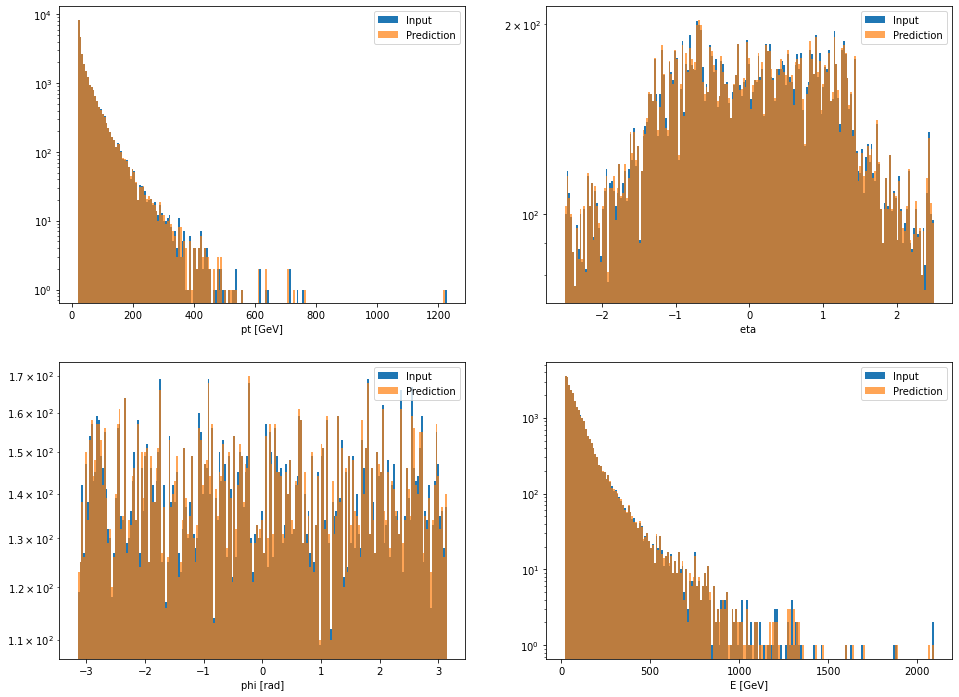

In [24]:
from satools import unnormalize

orig = test.copy()
pred = model(torch.tensor(orig, dtype=torch.float)).detach().numpy()

branches = ['pt', 'eta', 'phi', 'E']

orig = unnormalize(orig)
pred = unnormalize(pred)

n_bins = 200
fig = plt.figure(figsize=(16, 12))
for i in range(orig.shape[1]):
    plt.subplot(2, 2, i+1)
    bins = np.linspace(min(min(orig[:, i]), min(pred[:, i])), max(max(orig[:, i]), max(pred[:, i])), n_bins)
    _ = plt.hist(orig[:, i], bins=bins, density=False, label='Input')
    _ = plt.hist(pred[:, i], bins=bins, alpha=0.7, density=False, label='Prediction')
    plt.xlabel(branches[i] + ' ' + units[i])
    plt.yscale('log')
    plt.legend()

print('Viewing the ' + dataset_name)
print('Number of jets in test set:', len(orig))
print('Using AE architecture ' + model.describe())
if load:
    print('Model name: ' + load_filename)

### Calculate responses and residuals
The standard deviation of the responses and residuals should be small. In addition, the distributions of responses and residuals should ideally be zero-centered.

pt response mean: -3.7320508e-05
pt response std: 0.0016650391

eta residual mean: 5.6347126e-06
eta residual std: 0.0012229303

phi residual mean: -2.0439746e-05
phi residual std: 0.0009778246

E response mean: 5.6130142e-05
E response std: 0.002206306



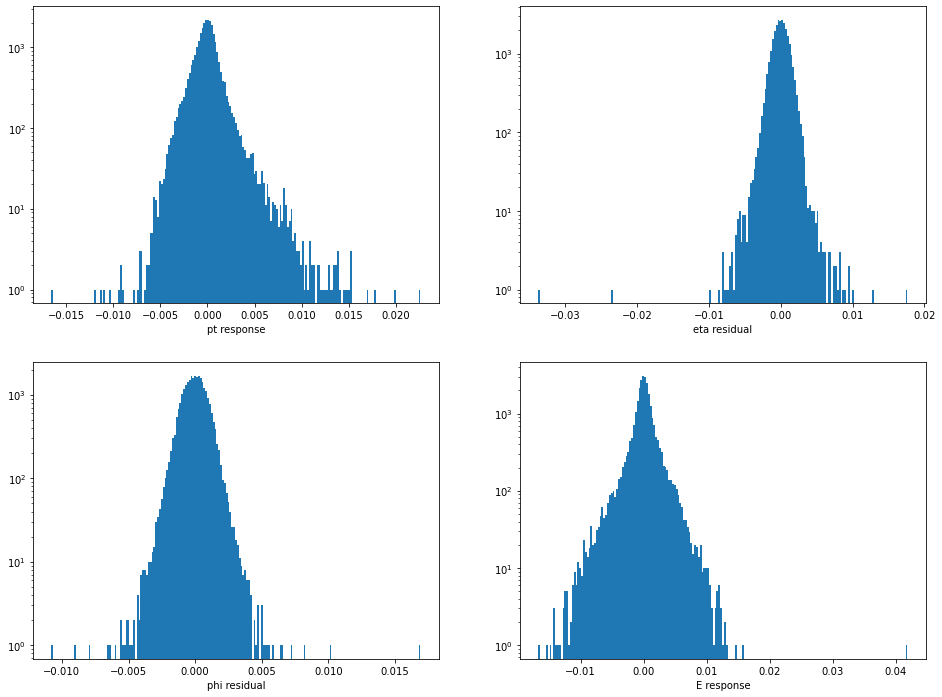

In [26]:
res = pred - orig
res[:, 0] /= orig[:, 0]
res[:, 3] /= orig[:, 3]

res_str = ['response', 'residual', 'residual', 'response']
n_bins = 200
ranges = [(min(res[:, i]), max(res[:, i])) for i in range(res.shape[1])]
limits = [np.linspace(a, b, n_bins) for (a, b) in ranges]

bin_edges = {}
bin_counts = {}
bin_max_ixs = {}

fig = plt.figure(figsize=(16, 12))
for i in range(res.shape[1]):
    plt.subplot(2, 2, i+1)
    branch = branches[i]
    bin_counts[branch], bin_edges[branch], _ = plt.hist(res[:, i], bins=limits[i], density=False)
    bin_max_ixs[branch] = np.where(bin_counts[branch] == bin_counts[branch].max())
    
    
    plt.xlabel(branch + ' ' + res_str[i])
    plt.yscale('log')
    print(branches[i] + ' ' + res_str[i] + ' mean:', res[:, i].mean())
    print(branches[i] + ' ' + res_str[i] + ' std:', res[:, i].std())
    print()

### Visualize correlations between the responses/residuals of the different variables
This can for example be used to see if the network is trading off accuracy in one variable for another.

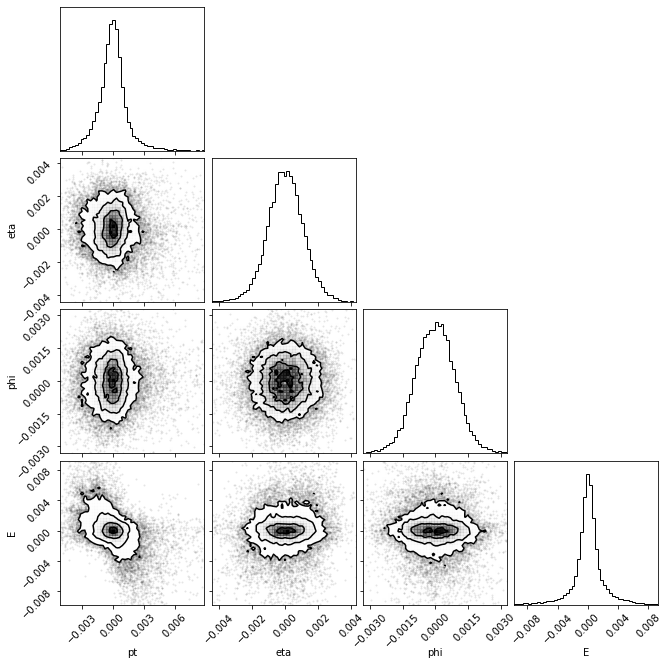

In [27]:
_ = corner.corner(res, range=[0.995 for _ in range(4)], labels=branches, bins=50)

### Initalizing the second network, collective encoding

In [28]:
# Define a collective AE model, activation function tanh

class CollectiveModel(nn.Module):
    def __init__(self, n_features=3, group_size=2, latent_space_size=5):
        super(CollectiveModel, self).__init__()
        self.latent_space_size = latent_space_size
        self.en1 = nn.Linear(n_features * group_size, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 50)
        self.en4 = nn.Linear(50, self.latent_space_size)
        self.de1 = nn.Linear(latent_space_size, 50)
        self.de2 = nn.Linear(50, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features * group_size)
        self.act = nn.Tanh()
    
    def encode(self, x):
        return self.en4(self.act(self.en3(self.act(self.en2(self.act(self.en1(x)))))))
    
    def decode(self, x):
        return self.de4(self.act(self.de3(self.act(self.de2(self.act(self.de1(self.act(x))))))))
    
    def forward(self, x, mode = 'both'):
        assert mode in ['both', 'encode', 'decode'], 'model expects keyword mode to be \'encode\', \'decode\' or \'both\'.'
        if mode == 'encode':
            return self.encode(x)
        elif mode == 'decode':
            return self.decode(x)
        else:
            z = self.encode(x)
            return self.decode(z)
    
    def describe(self):
        return 'in-200-200-50-' + str(self.latent_space_size) + '-50-200-200-out, activation function: ' + str(self.act)

In [29]:
group_size = 4
collective_latent_space_size = 10
    
print('Number of features in single-instance input data:', n_features)
print('Size of single-instance latent space representations:', latent_space_size)
print('Group size:', group_size)
print('Collective latent space size:', collective_latent_space_size)
print('Resulting total compression ratio:', group_size*n_features/collective_latent_space_size)
    
model2 = CollectiveModel(group_size=group_size, latent_space_size=collective_latent_space_size)
model2.to('cpu')
print(model2.describe())

Number of features in single-instance input data: 4
Size of single-instance latent space representations: 3
Group size: 4
Collective latent space size: 10
Resulting total compression ratio: 1.6
in-200-200-50-10-50-200-200-out, activation function: Tanh()


### Encode single jets using first network, and group them
The grouping is set up so that the data is first truncated to make sure that groups always consist of jets from the same event.

In [30]:
from satools import group, ungroup

collective_n_features = latent_space_size

multi_jet_events = jet_data.copy()

train_idxs = (0, int(len(multi_jet_events) * 4 / 5))
test_idxs = (train_idxs[1], len(multi_jet_events))

train_mje = multi_jet_events.iloc[train_idxs[0] : train_idxs[1] - 1] # Note that pandas indices are inclusive
test_mje = multi_jet_events.iloc[test_idxs[0] : test_idxs[1] - 1]

# Make sure groups are created with jets from the same events
# by ensuring that the list of data starts on a leading jet and ends on the final jet of an event
while train_mje.index[0][1] != 0:
    train_mje = train_mje.iloc[1:]
while train_mje.index[-1][1] != group_size - 1:
    train_mje = train_mje.iloc[:-1]
while test_mje.index[0][1] != 0:
    test_mje = test_mje.iloc[1:]
while test_mje.index[-1][1] != group_size - 1:
    test_mje = test_mje.iloc[:-1]

# Use the single-instance AE to encode training and testing data, then group them for use in the collective AE
c_train = group(model(torch.tensor(normalize(train_mje.values)), mode='encode'), group_size=group_size, n_features=latent_space_size).detach()
c_test = group(model(torch.tensor(normalize(test_mje.values)), mode='encode'), group_size=group_size, n_features=latent_space_size).detach()

batch_size = 256

c_dls = make_DataLoaders(c_train, c_test, batch_size)

In [31]:
# Set up the model and learner

loss_func2 = nn.MSELoss()

weight_decay2 = 1e-6

recorder2 = learner.Recorder()
learn2 = learner.Learner(c_dls, model=model2, wd=weight_decay2, loss_func=loss_func2, cbs=recorder2)

### As before, either load a saved model...

In [33]:
# Option to load a model

load_filename = 'd300-c1000'
load = True
if load:
    learn2.load(load_filename)
    print('Loaded model', load_filename)

Loaded model d300-c1000


### ...or train a new collective network

Learning rate with the minimum loss: 0.003981071710586548
Learning rate with the steepest gradient: 0.0008317637839354575


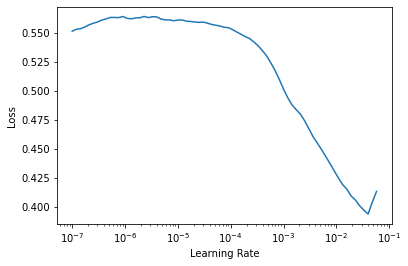

In [89]:
# Let Learner find learning rates

lr_min2, lr_steep2 = learn2.lr_find()

print('Learning rate with the minimum loss:', lr_min2)
print('Learning rate with the steepest gradient:', lr_steep2)

In [90]:
# Train the model

n_epoch2 = 1000
lr_max2 = lr_min2

print('Training collective AE:', model2.describe())

start = time.perf_counter() # Starts timer
learn2.fit_one_cycle(n_epoch=n_epoch2, lr_max=lr_max2)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

Training collective AE: in-200-200-50-10-50-200-200-out, activation function: Tanh()
[0, 0.10529039800167084, 0.07330767065286636, '00:02']
[0, 0.10529039800167084, 0.07330767065286636, '00:02']
[1, 0.01909707300364971, 0.016674140468239784, '00:02']
[1, 0.01909707300364971, 0.016674140468239784, '00:02']
[2, 0.014525662176311016, 0.014067881740629673, '00:03']
[2, 0.014525662176311016, 0.014067881740629673, '00:03']
[3, 0.008417120203375816, 0.008100410923361778, '00:02']
[3, 0.008417120203375816, 0.008100410923361778, '00:02']
[4, 0.007756668608635664, 0.007618180010467768, '00:02']
[4, 0.007756668608635664, 0.007618180010467768, '00:02']
[5, 0.00745961582288146, 0.007385192904621363, '00:02']
[5, 0.00745961582288146, 0.007385192904621363, '00:02']
[6, 0.007126659620553255, 0.007145501673221588, '00:02']
[6, 0.007126659620553255, 0.007145501673221588, '00:02']
[7, 0.006593271624296904, 0.006495505105704069, '00:02']
[7, 0.006593271624296904, 0.006495505105704069, '00:02']
[8, 0.00568

Loss as a function of batches trained:


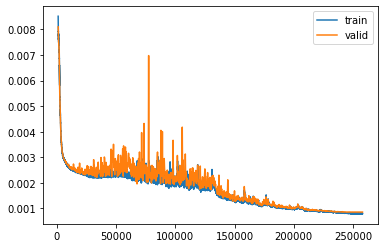


Learning rate and momentum as functions of batches trained:


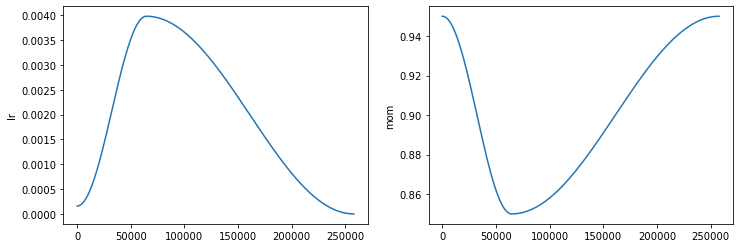

In [91]:
print('Loss as a function of batches trained:')
recorder2.plot_loss(skip_start = 1000)
plt.show()
print()
print('Learning rate and momentum as functions of batches trained:')
recorder2.plot_sched()
plt.show()

In [92]:
# Option to save the model

save_filename = '1013'
save = False
if os.path.isfile('./models/'+save_filename+'.pth'):
    save = False
    print('File already exists.')
if save:
    learn2.save(save_filename)

### Visualize the final results

Viewing the real data, F:\Master\Data\2lep\Data\data_B.2lep.root
Using AE architecture in-200-200-50-10-50-200-200-out, activation function: Tanh()
Model name: d300-c1000


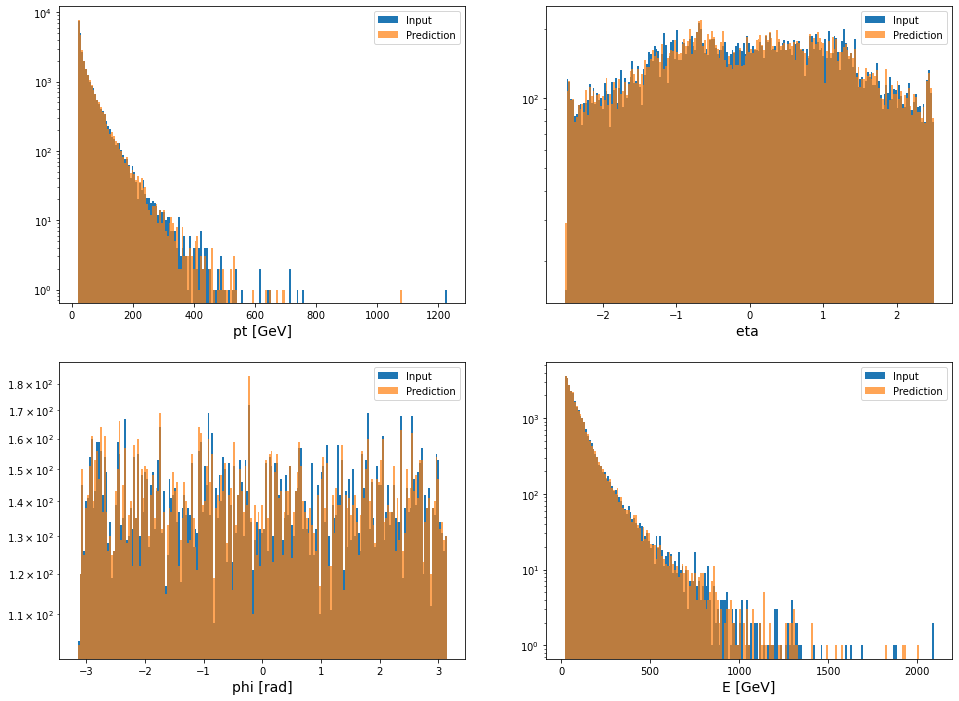

In [34]:
orig = normalize(test_mje.values.copy())
latent = model(torch.tensor(orig, dtype=torch.float), mode='encode').detach().numpy()
into_model2 = group(latent, group_size=group_size, n_features=latent_space_size)
out_model2 = ungroup(model2(torch.tensor(into_model2, dtype=torch.float)).detach().numpy(), group_size=group_size, n_features=latent_space_size)
pred = model(torch.tensor(out_model2, dtype=torch.float), mode='decode').detach().numpy()

orig = unnormalize(orig)
pred = unnormalize(pred)

branches = ['pt', 'eta', 'phi', 'E']
units = ['[GeV]', '', '[rad]', '[GeV]']
n_bins = 200
fig = plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    limits = (min(min(orig[:, i]), min(pred[:, i])), max(max(orig[:, i]), max(pred[:, i])))
    _ = plt.hist(orig[:, i], bins=np.linspace(limits[0], limits[1], n_bins), density=False, label='Input')
    _ = plt.hist(pred[:, i], bins=np.linspace(limits[0], limits[1], n_bins), alpha=0.7, density=False, label='Prediction')
    plt.xlabel(branches[i] + ' ' + units[i], fontsize=14)
    plt.yscale('log')
    plt.legend()

print('Viewing the ' + dataset_name)
print('Using AE architecture ' + model2.describe())
if load:
    print('Model name: ' + load_filename)

pt response mean: 0.0016835182
pt response std: 0.08293519

eta residual mean: 0.00023082705
eta residual std: 0.05727502

phi residual mean: 9.583115e-05
phi residual std: 0.0058923014

E response mean: 0.000116380645
E response std: 0.06911931



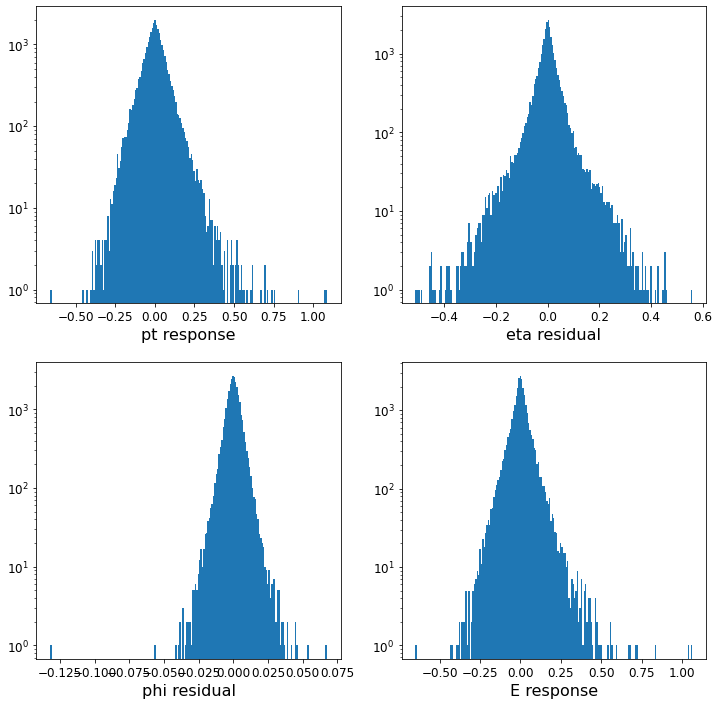

In [36]:
# Calculate responses and residuals

c_res = pred - orig
c_res[:, 0] /= orig[:, 0]
c_res[:, 3] /= orig[:, 3]

res_str = ['response', 'residual', 'residual', 'response']
n_bins = 200
ranges = [(min(c_res[:, i]), max(c_res[:, i])) for i in range(c_res.shape[1])]
limits = [np.linspace(a, b, n_bins) for (a, b) in ranges]

fig = plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    _ = plt.hist(c_res[:, i], bins=limits[i], density=False)
    plt.xlabel(branches[i] + ' ' + res_str[i], fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale('log')
    print(branches[i] + ' ' + res_str[i] + ' mean:', c_res[:, i].mean())
    print(branches[i] + ' ' + res_str[i] + ' std:', c_res[:, i].std())
    print()

### Visualize correlations between the responses/residuals of the different variables, after collective compression
At a total compression ratio of 1.6, there appears to be a strong correlation between the error in pt and in E. When you go beyond a 4/3 compression ratio, the network becomes increasingly unable to recover the variables. Intuitively, you could expect that the correlation be the opposite - that a large error in pt corresponds to a small error in E. Interestingly that is not the case, with a large error in pt instead corresponding to a large error in E.

Pt and E are correlated variables, so it is possible that the network utilizes this correlation in the compression. Eta is very weakly correlated to pt and E (see below), and phi is completely independent, so it seems to be reasonable that when the network reduces the dimensionality of the data, it uses the information shared between pt and E. Since the correlation between pt and E isn't stronger, information is lost in this process, and the error in both variables is pulled in the same direction.

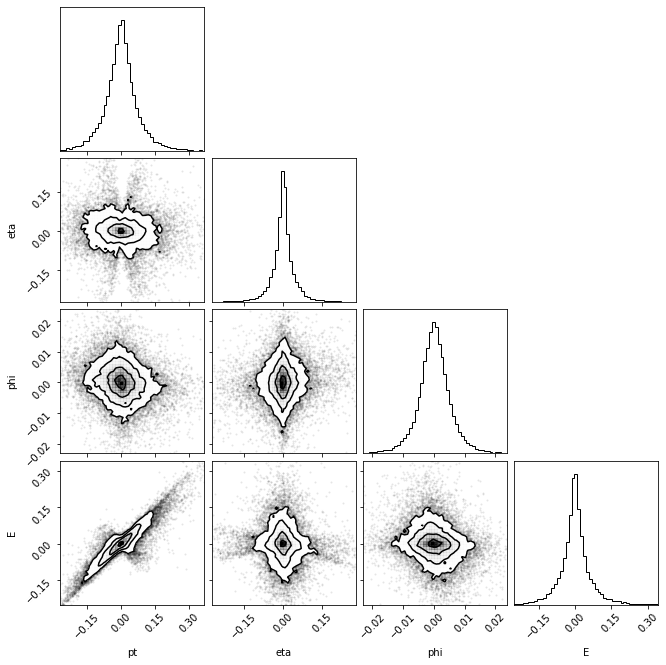

In [37]:
_ = corner.corner(c_res, range=[0.995 for _ in range(4)], labels=branches, bins=50)

### Correlations between input variables

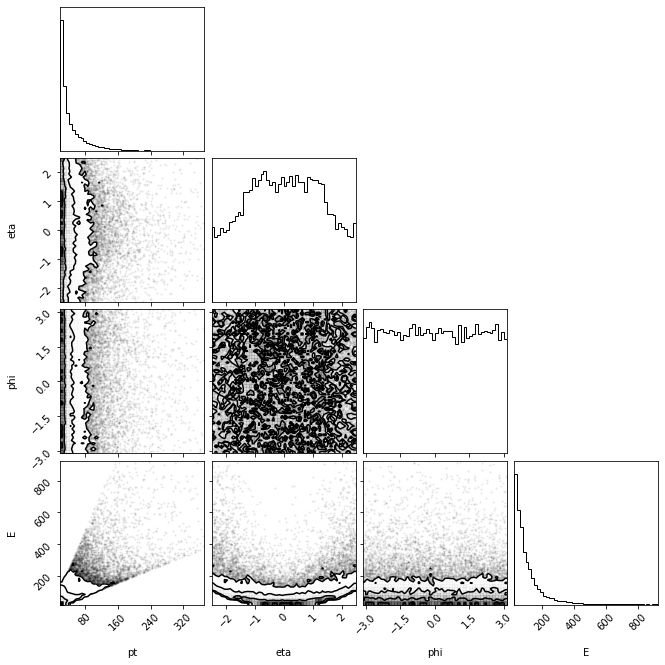

In [41]:
_ = corner.corner(orig, bins=50, labels=branches, range=[0.995 for _ in range(4)])